# Sequential Q-learning

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [40]:
import gym
import numpy as np

In [41]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [42]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [43]:
env.reset()
for _ in range(10):
    # env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

state, action, reward, done, info: [-0.02301832  0.23638743  0.01045034 -0.30979822] 1 1.0 False {}
state, action, reward, done, info: [-0.01829057  0.04111816  0.00425438 -0.01383796] 0 1.0 False {}
state, action, reward, done, info: [-0.0174682   0.23617884  0.00397762 -0.30517554] 1 1.0 False {}
state, action, reward, done, info: [-0.01274463  0.04100043 -0.00212589 -0.01124083] 0 1.0 False {}
state, action, reward, done, info: [-0.01192462  0.23615281 -0.00235071 -0.30459374] 1 1.0 False {}
state, action, reward, done, info: [-0.00720156  0.43130818 -0.00844258 -0.5980171 ] 1 1.0 False {}
state, action, reward, done, info: [ 0.0014246   0.62654724 -0.02040292 -0.89334734] 1 1.0 False {}
state, action, reward, done, info: [ 0.01395555  0.82193988 -0.03826987 -1.19237335] 1 1.0 False {}
state, action, reward, done, info: [ 0.03039434  0.62733401 -0.06211734 -0.91192688] 0 1.0 False {}
state, action, reward, done, info: [ 0.04294102  0.43310503 -0.08035587 -0.63939606] 0 1.0 False {}


To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [44]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [45]:
def model_input(state_size, lstm_size, batch_size=1):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    # RNN
    gru = tf.nn.rnn_cell.GRUCell(lstm_size)
    cell = tf.nn.rnn_cell.MultiRNNCell([gru], state_is_tuple=False)
    initial_state = cell.zero_state(batch_size, tf.float32)
    return states, actions, targetQs, cell, initial_state

In [46]:
# RNN generator or sequence generator
def generator(states, initial_state, cell, lstm_size, num_classes, reuse=False): 
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        inputs = tf.layers.dense(inputs=states, units=lstm_size)
        print(states.shape, inputs.shape)
        
        # with tf.variable_scope('dynamic_rnn_', reuse=tf.AUTO_REUSE):
        # dynamic means adapt to the batch_size
        inputs_rnn = tf.reshape(inputs, [1, -1, lstm_size]) # NxH -> 1xNxH
        print(inputs_rnn.shape, initial_state.shape)
        outputs_rnn, final_state = tf.nn.dynamic_rnn(cell=cell, inputs=inputs_rnn, initial_state=initial_state)
        print(outputs_rnn.shape, final_state.shape)
        outputs = tf.reshape(outputs_rnn, [-1, lstm_size]) # 1xNxH -> NxH
        print(outputs.shape)

        # Last fully connected layer
        logits = tf.layers.dense(inputs=outputs, units=num_classes)
        print(logits.shape)
        #predictions = tf.nn.softmax(logits)
        
        # logits are the action logits
        return logits, final_state

In [47]:
def model_loss(action_size, hidden_size, states, cell, initial_state, actions, targetQs):
    actions_logits, final_state = generator(states=states, cell=cell, initial_state=initial_state, 
                                            lstm_size=hidden_size, num_classes=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, final_state, loss

In [48]:
def model_opt(loss, learning_rate):
    """
    Get optimization operations in order
    :param loss: Generator loss Tensor for action prediction
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # # Optimize
    # with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
    # #opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    #grads, _ = tf.clip_by_global_norm(t_list=tf.gradients(loss, g_vars), clip_norm=5) # usually around 1-5
    grads = tf.gradients(loss, g_vars)
    opt = tf.train.AdamOptimizer(learning_rate).apply_gradients(grads_and_vars=zip(grads, g_vars))

    return opt

In [49]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, cell, self.initial_state = model_input(
            state_size=state_size, lstm_size=hidden_size)
        
        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.final_state, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, 
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, cell=cell, initial_state=self.initial_state)

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [51]:
from collections import deque

class Memory():    
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
        self.states = deque(maxlen=max_size)
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), 
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.states[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [52]:
# print('state:', np.array(states).shape[1], 
#       'action size: {}'.format((np.max(np.array(actions)) - np.min(np.array(actions)))+1))

In [55]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 128            # memory capacity - 1000 DQN
batch_size = 128             # experience mini-batch size - 20 DQN
gamma = 0.99                 # future reward discount

In [56]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=batch_size)

(?, 4) (?, 64)
(1, ?, 64) (1, 64)
(1, ?, 64) (1, 64)
(?, 64)
(?, 2)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [57]:
state = env.reset()
# initial_state = np.zeros([1, hidden_size])
# final_state = np.zeros([1, hidden_size])
for _ in range(batch_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    #memory.states.append([initial_state, final_state])
    state = next_state
    if done is True:
        state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [58]:
# memory.buffer[0], memory.states[0]

In [59]:
# states, rewards, actions

In [ ]:
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        initial_state = sess.run(model.initial_state)

        # Training steps/batches
        while True:
            action_logits, final_state = sess.run([model.actions_logits, model.final_state],
                                                  feed_dict = {model.states: state.reshape([1, -1]), 
                                                               model.initial_state: initial_state})
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.states.append([initial_state, final_state])
            total_reward += reward
            initial_state = final_state
            state = next_state

            # Training
            #batch, rnn_states = memory.sample(batch_size)
            batch = memory.buffer
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            next_states = np.array([each[2] for each in batch])
            rewards = np.array([each[3] for each in batch])
            dones = np.array([each[4] for each in batch])
            rnn_states = memory.states
            initial_states = np.array([each[0] for each in rnn_states])
            final_states = np.array([each[1] for each in rnn_states])
            next_actions_logits = sess.run(model.actions_logits, 
                                           feed_dict = {model.states: next_states, 
                                                        model.initial_state: final_states[0].reshape([1, -1])})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs,
                                                        model.initial_state: initial_states[0].reshape([1, -1])})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model-qn-seq.ckpt')

Episode:0 meanR:71.0000 R:71.0 loss:2.0061 exploreP:0.9930
Episode:1 meanR:41.5000 R:12.0 loss:4.4033 exploreP:0.9918
Episode:2 meanR:31.0000 R:10.0 loss:4.4567 exploreP:0.9908
Episode:3 meanR:27.2500 R:16.0 loss:5.4879 exploreP:0.9893
Episode:4 meanR:25.0000 R:16.0 loss:7.3702 exploreP:0.9877
Episode:5 meanR:22.5000 R:10.0 loss:5.2478 exploreP:0.9867
Episode:6 meanR:21.4286 R:15.0 loss:4.6599 exploreP:0.9853
Episode:7 meanR:21.8750 R:25.0 loss:4.1861 exploreP:0.9828
Episode:8 meanR:22.4444 R:27.0 loss:3.9478 exploreP:0.9802
Episode:9 meanR:21.9000 R:17.0 loss:3.6066 exploreP:0.9786
Episode:10 meanR:21.2727 R:15.0 loss:3.5123 exploreP:0.9771
Episode:11 meanR:21.5833 R:25.0 loss:3.2292 exploreP:0.9747
Episode:12 meanR:21.3077 R:18.0 loss:2.0121 exploreP:0.9730
Episode:13 meanR:21.6429 R:26.0 loss:2.2170 exploreP:0.9705
Episode:14 meanR:21.4667 R:19.0 loss:2.7960 exploreP:0.9686
Episode:15 meanR:23.0000 R:46.0 loss:2.8862 exploreP:0.9642
Episode:16 meanR:24.4118 R:47.0 loss:2.8574 explor

Episode:136 meanR:22.9600 R:42.0 loss:13.2405 exploreP:0.7315
Episode:137 meanR:23.0900 R:28.0 loss:15.8385 exploreP:0.7295
Episode:138 meanR:23.1700 R:30.0 loss:16.0508 exploreP:0.7273
Episode:139 meanR:23.3000 R:46.0 loss:12.1054 exploreP:0.7240
Episode:140 meanR:23.4300 R:33.0 loss:9.2890 exploreP:0.7217
Episode:141 meanR:23.5300 R:23.0 loss:9.9810 exploreP:0.7200
Episode:142 meanR:23.3600 R:14.0 loss:9.8353 exploreP:0.7190
Episode:143 meanR:23.1000 R:24.0 loss:11.7200 exploreP:0.7173
Episode:144 meanR:23.0800 R:24.0 loss:11.6358 exploreP:0.7156
Episode:145 meanR:23.4800 R:63.0 loss:11.4331 exploreP:0.7112
Episode:146 meanR:23.7500 R:45.0 loss:9.0003 exploreP:0.7081
Episode:147 meanR:24.4500 R:88.0 loss:5.7654 exploreP:0.7019
Episode:148 meanR:24.5500 R:23.0 loss:5.4324 exploreP:0.7004
Episode:149 meanR:24.6200 R:22.0 loss:7.0173 exploreP:0.6988
Episode:150 meanR:24.5800 R:16.0 loss:8.9329 exploreP:0.6977
Episode:151 meanR:24.6700 R:21.0 loss:11.8309 exploreP:0.6963
Episode:152 mean

Episode:269 meanR:21.7000 R:9.0 loss:24.6852 exploreP:0.5420
Episode:270 meanR:21.6900 R:9.0 loss:27.0805 exploreP:0.5415
Episode:271 meanR:21.7200 R:15.0 loss:27.0511 exploreP:0.5407
Episode:272 meanR:21.6400 R:15.0 loss:26.7627 exploreP:0.5399
Episode:273 meanR:21.6600 R:15.0 loss:26.5549 exploreP:0.5391
Episode:274 meanR:21.3600 R:12.0 loss:26.1318 exploreP:0.5385
Episode:275 meanR:21.4600 R:39.0 loss:24.6400 exploreP:0.5364
Episode:276 meanR:21.5500 R:21.0 loss:21.4751 exploreP:0.5353
Episode:277 meanR:21.6700 R:26.0 loss:18.0290 exploreP:0.5340
Episode:278 meanR:21.6200 R:25.0 loss:15.7529 exploreP:0.5326
Episode:279 meanR:21.5800 R:15.0 loss:15.0250 exploreP:0.5319
Episode:280 meanR:21.7000 R:26.0 loss:12.0934 exploreP:0.5305
Episode:281 meanR:21.8200 R:27.0 loss:13.1557 exploreP:0.5291
Episode:282 meanR:21.8600 R:14.0 loss:13.6083 exploreP:0.5284
Episode:283 meanR:21.8000 R:14.0 loss:14.4337 exploreP:0.5277
Episode:284 meanR:21.7600 R:10.0 loss:16.4695 exploreP:0.5271
Episode:28

Episode:402 meanR:17.4900 R:10.0 loss:23.0497 exploreP:0.4324
Episode:403 meanR:17.4600 R:11.0 loss:23.6121 exploreP:0.4320
Episode:404 meanR:17.3400 R:9.0 loss:24.7235 exploreP:0.4316
Episode:405 meanR:17.2900 R:12.0 loss:24.8663 exploreP:0.4311
Episode:406 meanR:17.1600 R:10.0 loss:24.7697 exploreP:0.4307
Episode:407 meanR:17.1400 R:11.0 loss:24.7513 exploreP:0.4302
Episode:408 meanR:17.2200 R:19.0 loss:23.6844 exploreP:0.4294
Episode:409 meanR:17.1700 R:10.0 loss:23.2299 exploreP:0.4290
Episode:410 meanR:17.2600 R:22.0 loss:21.7727 exploreP:0.4281
Episode:411 meanR:17.2700 R:13.0 loss:20.4852 exploreP:0.4275
Episode:412 meanR:17.2900 R:17.0 loss:19.7990 exploreP:0.4268
Episode:413 meanR:17.3000 R:15.0 loss:18.9936 exploreP:0.4262
Episode:414 meanR:17.3300 R:14.0 loss:18.1955 exploreP:0.4256
Episode:415 meanR:17.3600 R:15.0 loss:17.5665 exploreP:0.4250
Episode:416 meanR:17.4400 R:20.0 loss:17.0331 exploreP:0.4241
Episode:417 meanR:17.4800 R:16.0 loss:16.4646 exploreP:0.4235
Episode:4

Episode:535 meanR:22.0900 R:10.0 loss:20.7216 exploreP:0.3334
Episode:536 meanR:22.1000 R:16.0 loss:20.0621 exploreP:0.3329
Episode:537 meanR:22.0700 R:10.0 loss:20.3980 exploreP:0.3325
Episode:538 meanR:22.0600 R:12.0 loss:20.5909 exploreP:0.3321
Episode:539 meanR:22.0300 R:11.0 loss:20.7945 exploreP:0.3318
Episode:540 meanR:22.0100 R:11.0 loss:21.2172 exploreP:0.3314
Episode:541 meanR:21.9200 R:10.0 loss:21.4794 exploreP:0.3311
Episode:542 meanR:21.8300 R:9.0 loss:21.6287 exploreP:0.3308
Episode:543 meanR:21.7600 R:10.0 loss:22.1565 exploreP:0.3305
Episode:544 meanR:21.7200 R:11.0 loss:22.4672 exploreP:0.3302
Episode:545 meanR:21.6600 R:12.0 loss:23.0261 exploreP:0.3298
Episode:546 meanR:21.5900 R:11.0 loss:22.7693 exploreP:0.3294
Episode:547 meanR:21.4900 R:17.0 loss:21.9358 exploreP:0.3289
Episode:548 meanR:21.4200 R:9.0 loss:21.7585 exploreP:0.3286
Episode:549 meanR:21.3700 R:10.0 loss:21.4925 exploreP:0.3283
Episode:550 meanR:21.3800 R:13.0 loss:21.1574 exploreP:0.3279
Episode:55

Episode:668 meanR:40.5900 R:25.0 loss:20.3530 exploreP:0.2169
Episode:669 meanR:40.6900 R:20.0 loss:25.8930 exploreP:0.2164
Episode:670 meanR:40.8100 R:22.0 loss:24.8430 exploreP:0.2160
Episode:671 meanR:40.9000 R:20.0 loss:29.2047 exploreP:0.2156
Episode:672 meanR:40.9800 R:20.0 loss:32.0448 exploreP:0.2152
Episode:673 meanR:41.0300 R:15.0 loss:32.6576 exploreP:0.2149
Episode:674 meanR:41.1100 R:18.0 loss:37.6643 exploreP:0.2145
Episode:675 meanR:41.2200 R:20.0 loss:39.8722 exploreP:0.2141
Episode:676 meanR:41.2400 R:14.0 loss:40.6113 exploreP:0.2138
Episode:677 meanR:41.3300 R:19.0 loss:39.9932 exploreP:0.2134
Episode:678 meanR:41.3500 R:18.0 loss:39.6812 exploreP:0.2130
Episode:679 meanR:41.4600 R:22.0 loss:39.0914 exploreP:0.2126
Episode:680 meanR:41.4400 R:18.0 loss:37.5114 exploreP:0.2122
Episode:681 meanR:41.5000 R:21.0 loss:35.5654 exploreP:0.2118
Episode:682 meanR:41.5000 R:20.0 loss:34.6045 exploreP:0.2114
Episode:683 meanR:41.5500 R:22.0 loss:32.4144 exploreP:0.2110
Episode:

Episode:801 meanR:45.4600 R:10.0 loss:27.3338 exploreP:0.1332
Episode:802 meanR:45.4600 R:11.0 loss:23.7661 exploreP:0.1330
Episode:803 meanR:45.4600 R:10.0 loss:20.4787 exploreP:0.1329
Episode:804 meanR:45.4900 R:12.0 loss:15.6901 exploreP:0.1327
Episode:805 meanR:45.4900 R:8.0 loss:23.5647 exploreP:0.1326
Episode:806 meanR:45.4600 R:9.0 loss:23.6103 exploreP:0.1325
Episode:807 meanR:45.4800 R:12.0 loss:22.8719 exploreP:0.1324
Episode:808 meanR:45.4900 R:12.0 loss:19.6772 exploreP:0.1322
Episode:809 meanR:45.5200 R:12.0 loss:16.5328 exploreP:0.1321
Episode:810 meanR:45.5300 R:10.0 loss:14.0625 exploreP:0.1320
Episode:811 meanR:45.5600 R:13.0 loss:12.8378 exploreP:0.1318
Episode:812 meanR:45.6000 R:14.0 loss:11.5607 exploreP:0.1316
Episode:813 meanR:45.5700 R:14.0 loss:11.0183 exploreP:0.1315
Episode:814 meanR:45.4300 R:15.0 loss:11.0899 exploreP:0.1313
Episode:815 meanR:45.0700 R:17.0 loss:11.1636 exploreP:0.1311
Episode:816 meanR:44.9400 R:15.0 loss:11.6818 exploreP:0.1309
Episode:81

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [30]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

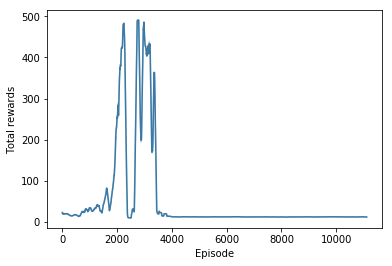

In [31]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

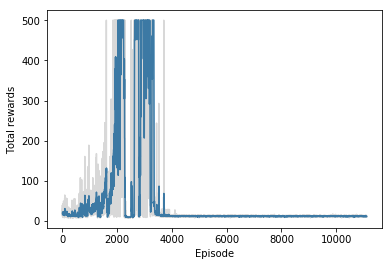

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Average losses')

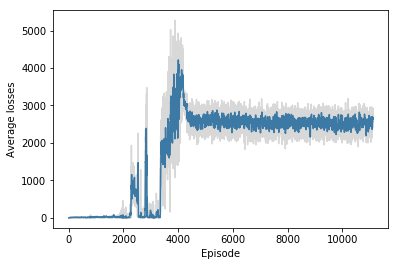

In [33]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [184]:
import gym

# Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model-seq.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    initial_state = sess.run(model.initial_state) # Qs or current batch or states[:-1]
    
    # Episode/epoch
    for _ in range(1):
        state = env.reset()
        total_reward = 0
        
        # Steps/batches
        while True:
            env.render()
            action_logits, initial_state = sess.run([model.actions_logits, model.final_state],
                                                    feed_dict = {model.states: state.reshape([1, -1]), 
                                                                 model.initial_state: initial_state})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # At the end of each episode
        print('total_reward:{}'.format(total_reward))

# Close the env
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward:120.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.